In [1]:
#  Ebnable HTML/CSS 
from IPython.core.display import HTML
HTML("<link href='https://fonts.googleapis.com/css?family=Passion+One' rel='stylesheet' type='text/css'><style>div.attn { font-family: 'Helvetica Neue'; font-size: 30px; line-height: 40px; color: #FFFFFF; text-align: center; margin: 30px 0; border-width: 10px 0; border-style: solid; border-color: #5AAAAA; padding: 30px 0; background-color: #DDDDFF; }hr { border: 0; background-color: #ffffff; border-top: 1px solid black; }hr.major { border-top: 10px solid #5AAA5A; }hr.minor { border: none; background-color: #ffffff; border-top: 5px dotted #CC3333; }div.bubble { width: 65%; padding: 20px; background: #DDDDDD; border-radius: 15px; margin: 0 auto; font-style: italic; color: #f00; }em { color: #AAA; }div.c1{visibility:hidden;margin:0;height:0;}div.note{color:red;}</style>")

___
Enter Team Member Names here (*double click to edit*):

- Name 1:
- Name 2:
- Name 3:

___

# In Class Assignment Two
In the following assignment you will be asked to fill in python code and derivations for a number of different problems. Please read all instructions carefully and turn in the rendered notebook (or HTML of the rendered notebook)  before the end of class (or right after class). The initial portion of this notebook is given before class and the remainder is given during class. Please answer the initial questions before class, to the best of your ability. Once class has started you may rework your answers as a team for the initial part of the assignment. 

<a id="top"></a>
## Contents
* <a href="#Loading">Loading the Data</a>
* <a href="#ff">Defining a Feedforward Network in Python</a>
* Available during in class assignment:
* <a href="#bp">Back Propagation in Python</a>
* <a href="#vis">Visualizing Back Propagation</a>
________________________________________________________________________________________________________

<a id="Loading"></a>
<a href="#top">Back to Top</a>
## Loading the Data
Please run the following code to read in the "digits" dataset from sklearn's data loading module. This data contains hand written digits for the characters 0-9.

This will load the data into the variable `ds`. `ds` is a `bunch` object with fields like `ds.data` and `ds.target`. The field `ds.data` is a numpy matrix of the continuous features in the dataset. **The object is not a pandas dataframe. It is a numpy matrix.** Each row is a set of observed instances, each column is a different feature. It also has a field called `ds.target` that is an integer value we are trying to predict (i.e., a specific integer represents a specific person). Each entry in `ds.target` is a label for each row of the `ds.data` matrix. 

In [1]:
# lets load up the handwritten digit dataset
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np

ds = load_digits()
X = ds.data/16.0-0.5
y = ds.target

print(X.shape)
print(y.shape)
print(np.min(X),np.max(X))
print(np.unique(y))

(1797, 64)
(1797,)
-0.5 0.5
[0 1 2 3 4 5 6 7 8 9]


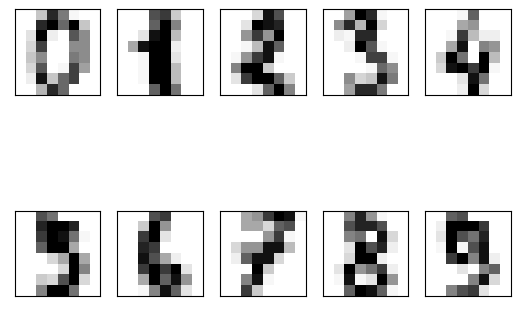

In [2]:
# reshape and print a few of the images in the digits dataset
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = X[i].reshape(8, 8)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.show()

____
**Question 1:** For the digits dataset, what does each column in $\mathbf{X}$ represent? What does each row in $\mathbf{X}$ represent? What does each value in $\mathbf{X}$ represent? What does each unique value of the target, $y$ represent?

*Enter you answer here (double click to edit)*



___

____
**Question 2:** For the digits dataset, we want to train a neural network with one hidden layer. The hidden layer will have 30 neurons. What will be the size of the matrices in each layer? That is, what is the size of $\mathbf{W}^{(1)}$ and what is the size of $\mathbf{W}^{(2)}$?



*Enter you answer here (double click to edit)*




___

<a id="ff"></a>
<a href="#top">Back to Top</a>

<img src="https://raw.githubusercontent.com/eclarson/MachineLearningNotebooks/master/PDF_Slides/MultiLayerNetwork.png" width="500">


# Defining a Feedforward Network

Below we will setup the functions for use in a feedforward neural network **with two layers**. Take a quick look at the functions defined. There are a number of convenience functions including:
- a function for the sigmoid calculation
- a function to one hot encode the output
- a function to add ones (for intercept/bias) terms on the row or column
- an initialization function for initializing the weights

A few functions are not yet implemented including:
- a `fit` function
- a `get_gradient` function

In [ ]:
# Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# Original Author: Sebastian Raschka

# This is the optional book we use in the course, excellent intuitions and straightforward programming examples
# please note, however, that this code has been manipulated to reflect our assumptions and notation.
import numpy as np
from scipy.special import expit
import sys
import pandas as pd

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_ + 1)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
        
        W2_num_elems = (self.n_hidden + 1)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden + 1)
        return W1, W2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = self._add_bias_unit(X.T, how='row')
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred

___
Recall from the videos that all instances in $\mathbf{X}$ can be fed into the network with a single matrix multiplication operation for each intermediate vector, $a^{(l)}$ and $z^{(l)}$. When we feed all the instances, $\mathbf{X}$, the intermediate vectors, $a^{(l)}$ and $z^{(l)}$ get stacked together to form matrices, $\mathbf{A}^{(l)}$ and $\mathbf{Z}^{(l)}$. This is already done for you in the `_feedforward` function defined above.

**Question 3:**
For the digits dataset we are using and a network with 30 neurons in the hidden layer, what are the sizes of:
- **Part A**: the intermediate vectors, $a^{(1)}$ and $a^{(2)}$
- **Part B**: the intermediate vectors, $z^{(1)}$ and $z^{(2)}$
- **Part C**: the intermediate matrices, $\mathbf{A}^{(1)}$ and $\mathbf{A}^{(2)}$
- **Part D**: the intermediate matrices, $\mathbf{Z}^{(1)}$ and $\mathbf{Z}^{(2)}$



*Enter you answer here (double click)*


A. 


B.  


C. 


D.  

___